In this notebook we use GCN to analyze the POIs networks

In [185]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
cd drive/MyDrive/Colab\ Notebooks

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks'
/content/drive/MyDrive/Colab Notebooks


In [187]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.layers import Dense
from keras.models import Sequential
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchtext
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch_geometric
import itertools
import nltk
import spacy
import random
from tqdm import tqdm
import time
from IPython.display import Javascript

In [188]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter
import random
import csv
import os
import sys

In [189]:
random.seed(10)

In [190]:
df = pd.read_csv('./datasets/la_label.csv')

In [191]:
df.tail(10)

,Unnamed: 0,Label (Grouping),Unemployment Rate,"Agriculture, forestry, fishing and hunting, and mining",Construction,Manufacturing,Wholesale trade,Retail trade,"Transportation and warehousing, and utilities",Information,...,typology_y,typ_cat_y,label_y,USPS,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
1727,1727,9203.36,0.07,0.00,0.07,0.08,0.01,0.09,0.06,0.02,...,1.0,['LISD'],0.0,CA,1656822,967,0.640,0.000,34.385597,-118.535884
1728,1728,9203.37,0.08,0.00,0.11,0.14,0.01,0.11,0.04,0.04,...,6.0,['SMMI'],0.0,CA,1648101,0,0.636,0.000,34.373662,-118.512874
1729,1729,9203.38,0.09,0.00,0.03,0.09,0.04,0.09,0.03,0.09,...,9.0,['SAE'],0.0,CA,3715461,0,1.435,0.000,34.386084,-118.596430
1730,1730,9203.39,0.05,0.01,0.04,0.13,0.03,0.10,0.02,0.07,...,9.0,['SAE'],0.0,CA,33718926,228821,13.019,0.088,34.415357,-118.612172
1731,1731,9303.01,0.00,0.00,0.10,0.08,0.11,0.13,0.00,0.00,...,6.0,['SMMI'],0.0,CA,1028565621,4125839,397.131,1.593,34.280333,-117.866141
1732,1732,9800.15,0.12,0.00,0.13,0.07,0.02,0.08,0.05,0.00,...,1.0,['LISD'],0.0,CA,5188936,220674,2.003,0.085,33.773247,-118.288839
1733,1733,9800.19,0.09,0.00,0.00,0.00,0.10,0.05,0.11,0.05,...,9.0,['SAE'],0.0,CA,44210349,31076,17.070,0.012,34.092567,-118.534363
1734,1734,9800.21,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,2.0,['OD'],0.0,CA,6380469,565373,2.464,0.218,34.270047,-118.381334
1735,1735,9800.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.0,['ARE'],0.0,CA,12492183,13434637,4.823,5.187,33.739090,-118.258539
1736,1736,9901.00,-,-,-,-,-,-,-,-,...,3.0,['ARG'],1.0,CA,5606686,1665633,2.165,0.643,32.685362,-117.245574


In [192]:
df.columns

Index(['Unnamed: 0', 'Label (Grouping)', 'Unemployment Rate',
       'Agriculture, forestry, fishing and hunting, and mining',
       'Construction', 'Manufacturing', 'Wholesale trade', 'Retail trade',
       'Transportation and warehousing, and utilities', 'Information',
       'Finance and insurance, and real estate and rental and leasing',
       'Professional, scientific, and management, and administrative and waste management services',
       'Educational services, and health care and social assistance',
       'Arts, entertainment, and recreation, and accommodation and food services',
       'Other services, except public administration', 'Public administration',
       'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Less than $10,000',
       'HEALTH INSURANCE COVERAGE With health insurance coverage',
       'HEALTH INSURANCE COVERAGE With private health insurance',
       'YEAR STRUCTURE BUILT Built 2014 or later',
       'YEAR STRUCTURE BUILT Built 2010 to 2013',
  

In [193]:
ids = df['GEOID']
labels = df['label_y']
lats = df['INTPTLAT']
longs = df['INTPTLONG                                                                                                                             ']

In [194]:
la_lat_n = 34.746448
la_lat_s = 33.4
la_long_w = -118.861046
la_long_e = -117.015579

In [195]:
tracts = pd.DataFrame(list(zip(ids, lats, longs, labels)))
tracts.columns = ['id', 'lat', 'long', 'label']

In [196]:
tracts.describe()

,id,lat,long,label
count,1.737000e+03,1737.000000,1737.000000,1737.000000
mean,6.037900e+09,34.055732,-118.234390,0.157168
std,4.106899e+06,0.242663,0.240820,0.364063
min,6.037101e+09,32.683618,-118.861046,0.000000
25%,6.037211e+09,33.954281,-118.385506,0.000000
50%,6.037408e+09,34.055860,-118.265898,0.000000
75%,6.037570e+09,34.160209,-118.124438,0.000000
max,6.073010e+09,34.746448,-117.015579,1.000000


In [197]:
tracts.tail(10)

,id,lat,long,label
1727,6.037920e+09,34.385597,-118.535884,0.0
1728,6.037920e+09,34.373662,-118.512874,0.0
1729,6.037920e+09,34.386084,-118.596430,0.0
1730,6.037920e+09,34.415357,-118.612172,0.0
1731,6.037930e+09,34.280333,-117.866141,0.0
1732,6.037980e+09,33.773247,-118.288839,0.0
1733,6.037980e+09,34.092567,-118.534363,0.0
1734,6.037980e+09,34.270047,-118.381334,0.0
1735,6.037980e+09,33.739090,-118.258539,0.0
1736,6.073010e+09,32.685362,-117.245574,1.0


In [198]:
for index, row in tracts.iterrows():
    if (row['lat'] > la_lat_n or row['lat'] < la_lat_s or
            row['long'] > la_long_e or row['long'] < la_long_w):
        tracts = tracts.drop([index])

In [199]:
city_graph = nx.Graph()
color_map = []
for index, row in tracts.iterrows():
    city_graph.add_node((row['long'], row['lat']),
                        pos=(row['long'], row['lat']),
                        label=row['label'])
    if row['label'] == 1:
        color_map.append('purple')
    else:
        color_map.append('lightblue')

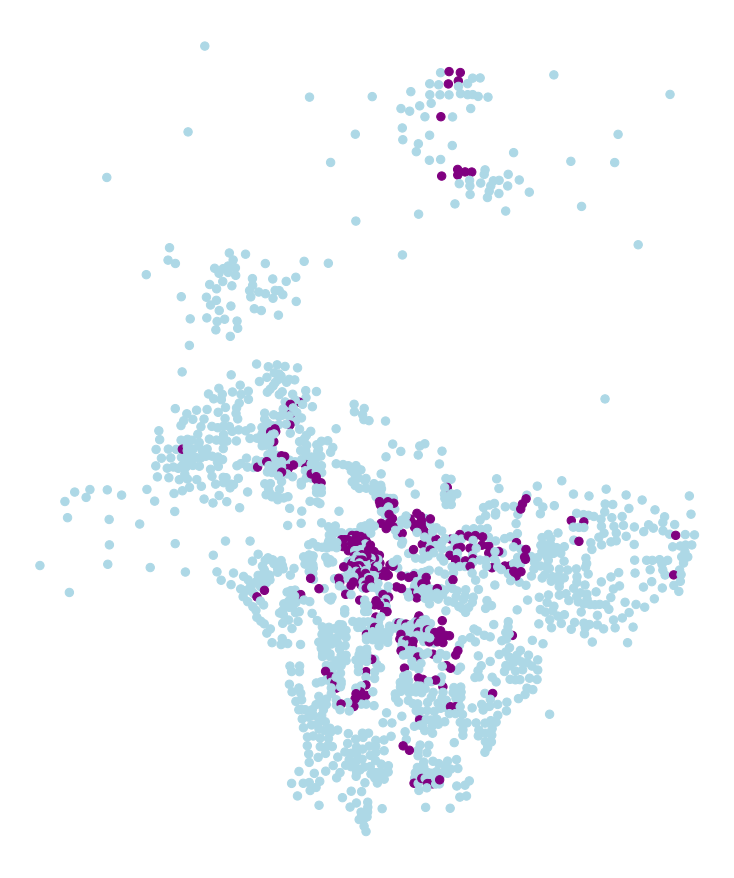

In [200]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [201]:
def get_distance(p1, p2):
    dist = math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    return dist

In [202]:
hospital_locations = pd.read_csv('./datasets/la_hospitals.csv')
hospital_x = hospital_locations

In [203]:
hospitals_x = hospital_locations['X']
hospitals_y = hospital_locations['Y']

hospitals = []
for n_long, n_lat in list(zip(hospitals_x, hospitals_y)):
    if (n_lat<=la_lat_n and n_lat>=la_lat_s and
            n_long<=la_long_e and n_long>=la_long_w):
        hospitals.append([n_long, n_lat, 0])

In [204]:
min(hospitals_y)

33.3391852280922

In [205]:
for i, hospital in enumerate(hospitals):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (hospital[0], hospital[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    hospitals[i][2] = int(label)

In [207]:
for i, values in enumerate(hospitals):
    n_long, n_lat, n_label = values
    city_graph.add_node(i, pos=(n_long, n_lat))
    color_map.append('orange')

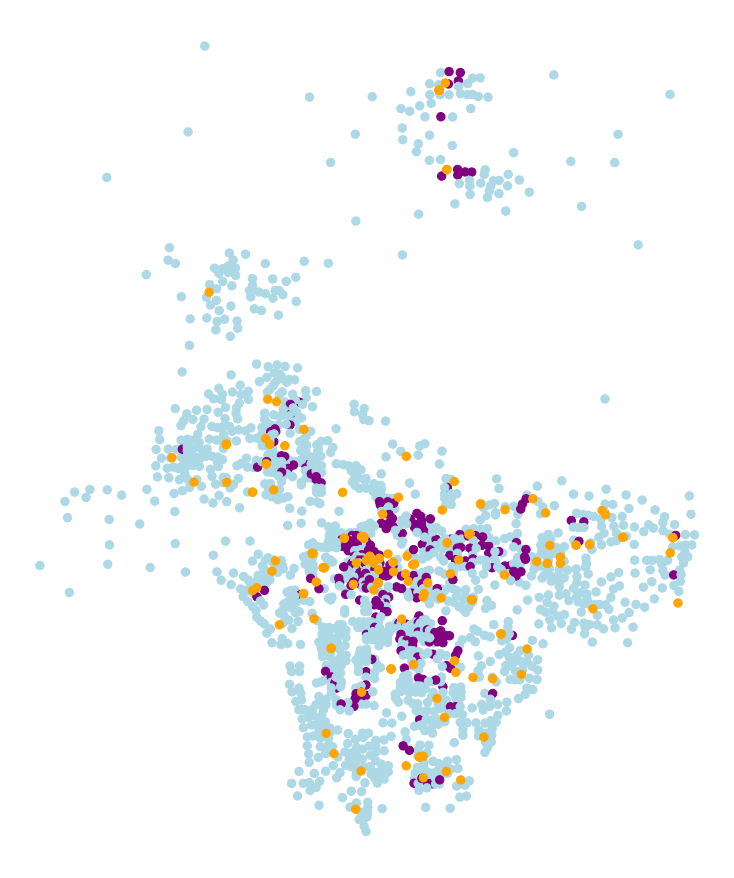

In [208]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [209]:
subway_locations = pd.read_csv('./datasets/la_subway.csv')
subway_x = subway_locations['X']
subway_y = subway_locations['Y']

subway = []
for n_long, n_lat in list(zip(subway_x, subway_y)):
    if (n_lat<=la_lat_n and n_lat>=la_lat_s and
            n_long<=la_long_e and n_long>=la_long_w):
        subway.append([n_long, n_lat, 0])

In [210]:
for i, s in enumerate(subway):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (s[0], s[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    subway[i][2] = int(label)

In [211]:
school_locations = pd.read_csv('./datasets/la_schools.csv')
schools_x = school_locations['X']
schools_y = school_locations['Y']

schools = []
for n_long, n_lat in list(zip(schools_x, schools_y)):
    if (n_lat<=la_lat_n and n_lat>=la_lat_s and
            n_long<=la_long_e and n_long>=la_long_w):
        schools.append([n_long, n_lat, 0])

In [212]:
for i, s in enumerate(schools):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (s[0], s[1]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
    schools[i][2] = int(label)

In [213]:
tract_lats = tracts['lat'].tolist()
tract_longs = tracts['long'].tolist()
tract_labels = tracts['label'].tolist()

In [214]:
# Remove the components you are interested in seeing
all_nodes = list(zip(tract_longs, tract_lats, tract_labels)) + hospitals + subway + schools

In [215]:
tract_indices = list(range(0, len(tracts)))
all_indices = list(range(0, len(all_nodes)))
hospital_indices = list(range(len(tracts), len(tracts) + len(hospitals)))
subway_indices = list(range(len(tracts) + len(hospitals), len(tracts) + len(hospitals) + len(subway)))
school_indices = list(range(len(tracts) + len(hospitals) + len(subway), len(tracts) + len(hospitals) + len(subway) + len(schools)))

In [216]:
len(hospitals), len(hospital_indices)

(164, 164)

In [217]:
# Creating a graph using NetworkX

# Adding nodes
city_graph = nx.Graph()
color_map = []
for i, values in enumerate(all_nodes):
    n_long, n_lat, n_label = values

    city_graph.add_node(i, pos=(n_long, n_lat))

    if n_label == 1:
        color_map.append('purple')
    else:
        color_map.append('lightblue')

# Adding edges
# To observe only one of the networks comment out the unwanted sections
for tract_i in tract_indices+hospital_indices:
    hospital_dict = {}
    for hospital_i in hospital_indices:
        hospital_dict[hospital_i] = get_distance((all_nodes[hospital_i][0], all_nodes[hospital_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(hospital_dict, key=hospital_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

for tract_i in tract_indices+school_indices:
    school_dict = {}
    for school_i in school_indices:
        school_dict[school_i] = get_distance((all_nodes[school_i][0], all_nodes[school_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(school_dict, key=school_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

for tract_i in tract_indices+subway_indices:
    subway_dict = {}
    for subway_i in subway_indices:
        subway_dict[subway_i] = get_distance((all_nodes[subway_i][0], all_nodes[subway_i][1]),
                                             (all_nodes[tract_i][0], all_nodes[tract_i][1]))
    
    closest2 = sorted(subway_dict, key=subway_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i][1]
        s_long = all_nodes[i][0]
        distance = get_distance((all_nodes[tract_i][0], all_nodes[tract_i][1]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

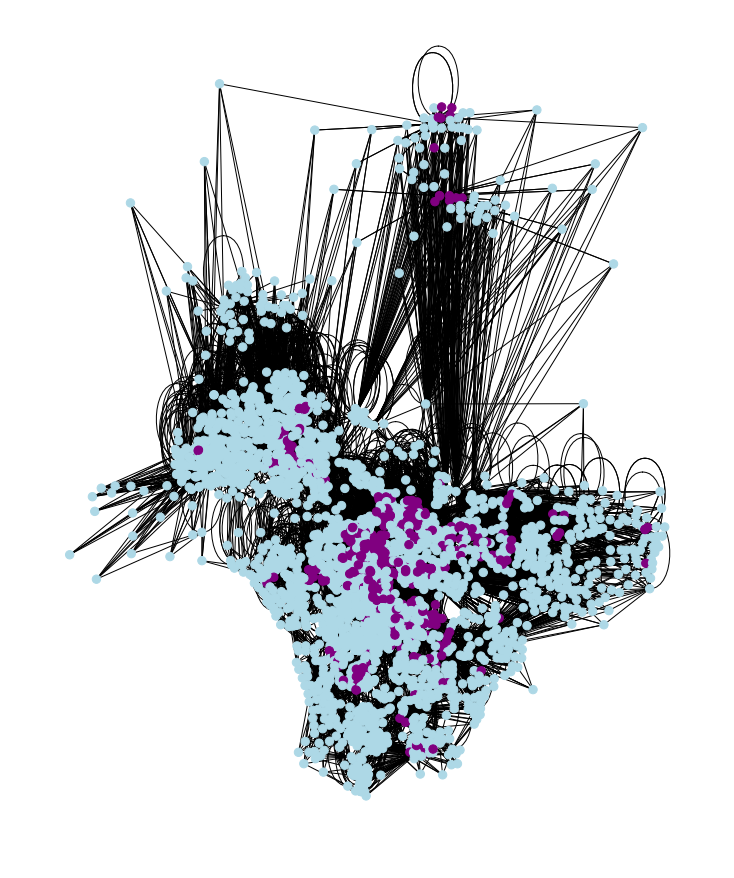

In [218]:
plt.figure(figsize=(10, 12))

pos=nx.get_node_attributes(city_graph,'pos')
nx.draw(city_graph, pos=pos,
        node_color=color_map, 
        with_labels=False,
        node_size=70)

In [219]:
tracts

,id,lat,long,label
0,6.037101e+09,34.259474,-118.292987,0.0
1,6.037101e+09,34.267721,-118.290147,0.0
2,6.037101e+09,34.252972,-118.290731,0.0
3,6.037101e+09,34.251608,-118.281633,0.0
4,6.037102e+09,34.225079,-118.354188,0.0
...,...,...,...,...
1731,6.037930e+09,34.280333,-117.866141,0.0
1732,6.037980e+09,33.773247,-118.288839,0.0
1733,6.037980e+09,34.092567,-118.534363,0.0
1734,6.037980e+09,34.270047,-118.381334,0.0


In [220]:
hospitals_graph = nx.Graph()
nodes = list(zip(tract_longs, tract_lats, tract_labels))+hospitals

for i, values in enumerate(nodes):
    n_long, n_lat, n_label = values
    hospitals_graph.add_node(i, pos=(n_long, n_lat))

# Adding edges
for tract_i,_ in enumerate(nodes):
    hospital_dict = {}
    for hospital_i,_ in enumerate(hospitals):
        hospital_i += len(tract_labels)
        hospital_dict[hospital_i] = get_distance((nodes[hospital_i][0], nodes[hospital_i][1]),
                                             (nodes[tract_i][0], nodes[tract_i][1]))
    
    closest2 = sorted(hospital_dict, key=hospital_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = nodes[i][1]
        s_long = nodes[i][0]
        distance = get_distance((nodes[tract_i][0], nodes[tract_i][1]),
                                (s_long, s_lat))
        hospitals_graph.add_edge(tract_i, i, weight=distance)


In [221]:
subway_graph = nx.Graph()
nodes = list(zip(tract_longs, tract_lats, tract_labels))+subway

for i, values in enumerate(nodes):
    n_long, n_lat, n_label = values
    subway_graph.add_node(i, pos=(n_long, n_lat))

# Adding edges
for tract_i,_ in enumerate(nodes):
    subway_dict = {}
    for subway_i,_ in enumerate(subway):
        subway_i += len(tract_labels)
        subway_dict[subway_i] = get_distance((nodes[subway_i][0], nodes[subway_i][1]),
                                             (nodes[tract_i][0], nodes[tract_i][1]))
    
    closest2 = sorted(subway_dict, key=subway_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = nodes[i][1]
        s_long = nodes[i][0]
        distance = get_distance((nodes[tract_i][0], nodes[tract_i][1]),
                                (s_long, s_lat))
        subway_graph.add_edge(tract_i, i, weight=distance)


In [222]:
schools_graph = nx.Graph()
nodes = list(zip(tract_longs, tract_lats, tract_labels))+schools

for i, values in enumerate(nodes):
    n_long, n_lat, n_label = values
    schools_graph.add_node(i, pos=(n_long, n_lat))

# Adding edges
for tract_i,_ in enumerate(nodes):
    schools_dict = {}
    for school_i,_ in enumerate(schools):
        school_i += len(tract_labels)
        schools_dict[school_i] = get_distance((nodes[school_i][0], nodes[school_i][1]),
                                             (nodes[tract_i][0], nodes[tract_i][1]))
    
    closest2 = sorted(schools_dict, key=schools_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = nodes[i][1]
        s_long = nodes[i][0]
        distance = get_distance((nodes[tract_i][0], nodes[tract_i][1]),
                                (s_long, s_lat))
        schools_graph.add_edge(tract_i, i, weight=distance)


In [227]:
def from_networkx(G, labels):
    G = nx.convert_node_labels_to_integers(G)
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
    data = {}
    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass
    data['edge_index'] = edge_index.view(2, -1)
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()
    data.x=torch.from_numpy(np.eye(data.num_nodes))

    all_indices = list(range(0, data.num_nodes))
    random.shuffle(all_indices)
    train_indices = all_indices[0:int(data.num_nodes*0.8)]
    test_indices = all_indices[int(data.num_nodes*0.8):data.num_nodes]

    train_mask = np.array([False]*data.num_nodes)
    train_mask[train_indices] = True
    data.train_mask = torch.from_numpy(train_mask)

    test_mask = np.array([False]*data.num_nodes)
    test_mask[test_indices] = True
    data.test_mask=torch.from_numpy(test_mask)
    
    data.y = torch.from_numpy(labels)
    
    return data

labels = [int(label) for _,_,label in all_nodes]
y = np.asarray(labels)

data = from_networkx(city_graph, y)

In [229]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        # super(GCN, self).__init__()
        # torch.manual_seed(12345)
        # self.conv1 = GCNConv(data.num_features, hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, 2)

        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, 4)

    def forward(self, x, edge_index):
        # x = self.conv1(x, edge_index)
        # x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)
        # x = self.conv2(x, edge_index)
        
        x = self.conv1(x, edge_index)
        x = x.tanh()
        x = self.conv2(x, edge_index)
        x = x.tanh()
        x = self.conv3(x, edge_index)
        x = x.tanh()  # Final GNN embedding space.
        out = self.classifier(x)

        return x

model = GCN(hidden_channels=16)
model.eval()
print(model)

GCN(
  (conv1): GCNConv(3186, 16)
  (conv2): GCNConv(16, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [230]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(dataset):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(dataset.x.to(torch.float), dataset.edge_index)  # Perform a single forward pass.
      loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(dataset):
      model.eval()
      out = model(dataset.x.to(torch.float), dataset.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(dataset.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 500):
    loss = train(data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6942
Epoch: 002, Loss: 0.5996
Epoch: 003, Loss: 0.5295
Epoch: 004, Loss: 0.4757
Epoch: 005, Loss: 0.4351
Epoch: 006, Loss: 0.4047
Epoch: 007, Loss: 0.3810
Epoch: 008, Loss: 0.3606
Epoch: 009, Loss: 0.3410
Epoch: 010, Loss: 0.3210
Epoch: 011, Loss: 0.3004
Epoch: 012, Loss: 0.2804
Epoch: 013, Loss: 0.2624
Epoch: 014, Loss: 0.2478
Epoch: 015, Loss: 0.2368
Epoch: 016, Loss: 0.2290
Epoch: 017, Loss: 0.2233
Epoch: 018, Loss: 0.2188
Epoch: 019, Loss: 0.2148
Epoch: 020, Loss: 0.2108
Epoch: 021, Loss: 0.2068
Epoch: 022, Loss: 0.2030
Epoch: 023, Loss: 0.1996
Epoch: 024, Loss: 0.1970
Epoch: 025, Loss: 0.1951
Epoch: 026, Loss: 0.1938
Epoch: 027, Loss: 0.1929
Epoch: 028, Loss: 0.1921
Epoch: 029, Loss: 0.1912
Epoch: 030, Loss: 0.1902
Epoch: 031, Loss: 0.1891
Epoch: 032, Loss: 0.1881
Epoch: 033, Loss: 0.1872
Epoch: 034, Loss: 0.1865
Epoch: 035, Loss: 0.1859
Epoch: 036, Loss: 0.1854
Epoch: 037, Loss: 0.1849
Epoch: 038, Loss: 0.1845
Epoch: 039, Loss: 0.1842
Epoch: 040, Loss: 0.1839


In [231]:
out = model(data.x.to(torch.float), data.edge_index)

In [232]:
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8668


In [233]:
data = from_networkx(hospitals_graph, y[tract_indices+hospital_indices])
model = GCN(hidden_channels=16)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 500):
    loss = train(data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

out = model(data.x.to(torch.float), data.edge_index)
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')

GCN(
  (conv1): GCNConv(1878, 16)
  (conv2): GCNConv(16, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)
Epoch: 001, Loss: 0.6927
Epoch: 002, Loss: 0.6326
Epoch: 003, Loss: 0.5786
Epoch: 004, Loss: 0.5296
Epoch: 005, Loss: 0.4860
Epoch: 006, Loss: 0.4486
Epoch: 007, Loss: 0.4178
Epoch: 008, Loss: 0.3931
Epoch: 009, Loss: 0.3732
Epoch: 010, Loss: 0.3564
Epoch: 011, Loss: 0.3413
Epoch: 012, Loss: 0.3266
Epoch: 013, Loss: 0.3116
Epoch: 014, Loss: 0.2958
Epoch: 015, Loss: 0.2792
Epoch: 016, Loss: 0.2625
Epoch: 017, Loss: 0.2466
Epoch: 018, Loss: 0.2327
Epoch: 019, Loss: 0.2214
Epoch: 020, Loss: 0.2128
Epoch: 021, Loss: 0.2062
Epoch: 022, Loss: 0.2010
Epoch: 023, Loss: 0.1966
Epoch: 024, Loss: 0.1929
Epoch: 025, Loss: 0.1897
Epoch: 026, Loss: 0.1869
Epoch: 027, Loss: 0.1843
Epoch: 028, Loss: 0.1820
Epoch: 029, Loss: 0.1798
Epoch: 030, Loss: 0.1778
Epoch: 031, Loss: 0.1759
Epoch: 032, Loss: 0.1742
Epoch: 033, Loss: 0.1728
Epoch: 034, Loss: 0.171

In [234]:
data = from_networkx(subway_graph, y[tract_indices+subway_indices])
model = GCN(hidden_channels=16)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 500):
    loss = train(data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

out = model(data.x.to(torch.float), data.edge_index)
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')

GCN(
  (conv1): GCNConv(1809, 16)
  (conv2): GCNConv(16, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)
Epoch: 001, Loss: 0.6932
Epoch: 002, Loss: 0.6516
Epoch: 003, Loss: 0.6116
Epoch: 004, Loss: 0.5730
Epoch: 005, Loss: 0.5366
Epoch: 006, Loss: 0.5032
Epoch: 007, Loss: 0.4735
Epoch: 008, Loss: 0.4473
Epoch: 009, Loss: 0.4244
Epoch: 010, Loss: 0.4043
Epoch: 011, Loss: 0.3862
Epoch: 012, Loss: 0.3694
Epoch: 013, Loss: 0.3535
Epoch: 014, Loss: 0.3379
Epoch: 015, Loss: 0.3222
Epoch: 016, Loss: 0.3065
Epoch: 017, Loss: 0.2908
Epoch: 018, Loss: 0.2757
Epoch: 019, Loss: 0.2615
Epoch: 020, Loss: 0.2488
Epoch: 021, Loss: 0.2377
Epoch: 022, Loss: 0.2282
Epoch: 023, Loss: 0.2202
Epoch: 024, Loss: 0.2136
Epoch: 025, Loss: 0.2082
Epoch: 026, Loss: 0.2036
Epoch: 027, Loss: 0.1997
Epoch: 028, Loss: 0.1961
Epoch: 029, Loss: 0.1929
Epoch: 030, Loss: 0.1899
Epoch: 031, Loss: 0.1872
Epoch: 032, Loss: 0.1848
Epoch: 033, Loss: 0.1826
Epoch: 034, Loss: 0.180

In [235]:
data = from_networkx(schools_graph, y[tract_indices+school_indices])
model = GCN(hidden_channels=16)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 500):
    loss = train(data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

out = model(data.x.to(torch.float), data.edge_index)
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')

GCN(
  (conv1): GCNConv(2927, 16)
  (conv2): GCNConv(16, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)
Epoch: 001, Loss: 0.6929
Epoch: 002, Loss: 0.5872
Epoch: 003, Loss: 0.5047
Epoch: 004, Loss: 0.4434
Epoch: 005, Loss: 0.3997
Epoch: 006, Loss: 0.3683
Epoch: 007, Loss: 0.3439
Epoch: 008, Loss: 0.3222
Epoch: 009, Loss: 0.3008
Epoch: 010, Loss: 0.2791
Epoch: 011, Loss: 0.2578
Epoch: 012, Loss: 0.2383
Epoch: 013, Loss: 0.2218
Epoch: 014, Loss: 0.2089
Epoch: 015, Loss: 0.1993
Epoch: 016, Loss: 0.1923
Epoch: 017, Loss: 0.1871
Epoch: 018, Loss: 0.1827
Epoch: 019, Loss: 0.1789
Epoch: 020, Loss: 0.1753
Epoch: 021, Loss: 0.1720
Epoch: 022, Loss: 0.1691
Epoch: 023, Loss: 0.1667
Epoch: 024, Loss: 0.1649
Epoch: 025, Loss: 0.1636
Epoch: 026, Loss: 0.1628
Epoch: 027, Loss: 0.1622
Epoch: 028, Loss: 0.1615
Epoch: 029, Loss: 0.1608
Epoch: 030, Loss: 0.1600
Epoch: 031, Loss: 0.1593
Epoch: 032, Loss: 0.1586
Epoch: 033, Loss: 0.1582
Epoch: 034, Loss: 0.158